In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

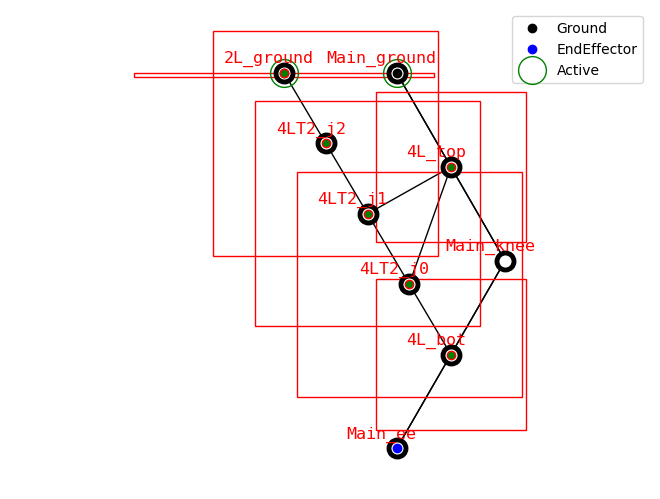

In [2]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[8]

actuator = TMotor_AK10_9()
# actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

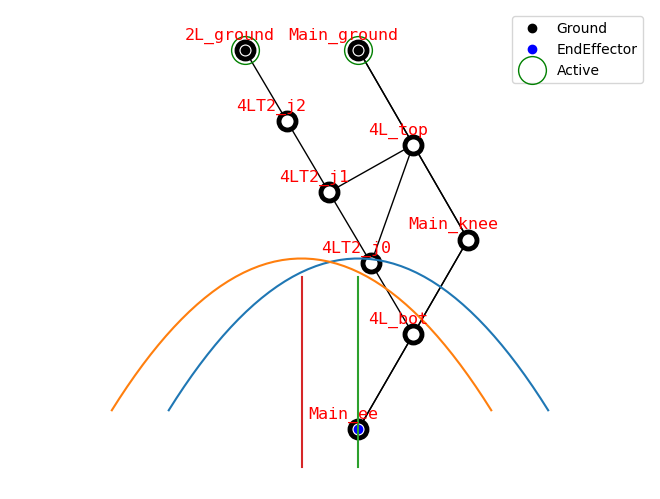

In [3]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -0.95], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -0.95], step_height= 0.4, step_width=1,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.15,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.15,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, left_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [4]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])


Best trajectory id: 1 partial rewards at best trajectory: [-0.02842190930370254, 0]
Best trajectory id: 1 partial rewards at best trajectory: [-0.00458044074421634, 0]


In [5]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [6]:
population_size = 32
n_generations = 60

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


0
0
0
00

00
0

0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
0
000

0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

00

0
0
0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

00

00
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
0
0
00

0
0
0
00

000


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
000


0
0
00

0
0
00

0
0
0
0
0
0
0
0
0
0
00

0
0
0
0
0
0
0
0
0
0
00

0
0
00

0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
0
0
00

0
0
0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

00

00

0
0
00

00
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
0
0
00

0
0
0
0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
00

0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
000


00

0
0
0
0
0
00
0

00

0
0
0
0
0
0
0
0
0
0
00

0
0
0
00

0
0
00
0

00

0
0
0
00

0
00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
00

0
0
00

0
0
0
0
0
0


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  0.0004907626 | -1.460235E+00
     2 |       64 |  0.17839 |       3 |  0.5146 |  2.00000 |  2.01680 | -3.428724E-01 | -2.977711E+00
     3 |       96 |  0.17012 |       3 |  0.5092 |  1.99174 |  2.02507 | -1.093926E+00 | -3.117438E+00
     4 |      128 |  0.05915 |       3 |  0.4374 |  1.98380 |  2.04444 | -1.514742E+00 | -3.117438E+00
     5 |      160 | -3.9E-02 |       3 |  0.3758 |  1.97052 |  2.05752 | -1.778237E+00 | -3.301555E+00
     6 |      192 | -3.6E-02 |       3 |  0.3779 |  1.95767 |  2.06951 | -1.942705E+00 | -3.301555E+00
     7 |      224 | -3.1E-02 |       3 |  0.3811 |  1.94566 |  2.08294 | -2.242672E+00 | -3.331103E+00
     8 |      256 | -1.7E-02 |       3 |  0.3894 |  1.93298 |  2.09088 | -2.492320E+00 | -3.676734E+00
     9 |      288 |  0.19244 |       3 |  0.5237 |  1.92292 |  2.10092 | 

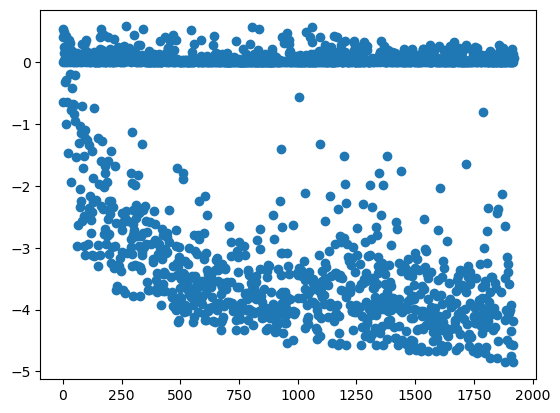

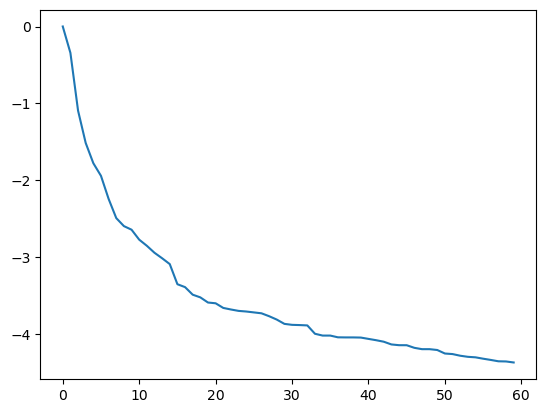

In [7]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [8]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.5825910112083514


The minimum result in optimization task: [-4.85498563]


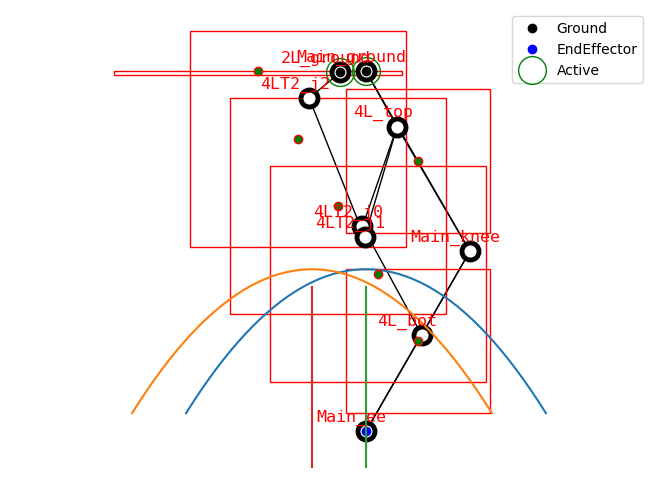

In [9]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [10]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.00000000e+00,  0.00000000e+00,  4.85555161e+00],
       [ 1.00000000e+00, -5.65972670e-04,  0.00000000e+00]])

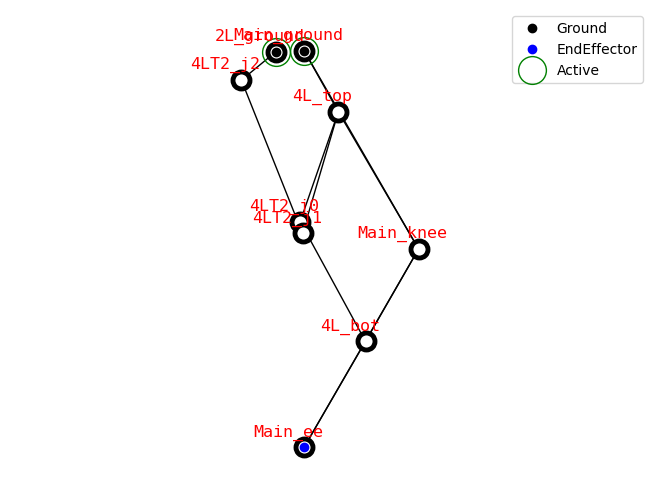

In [11]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

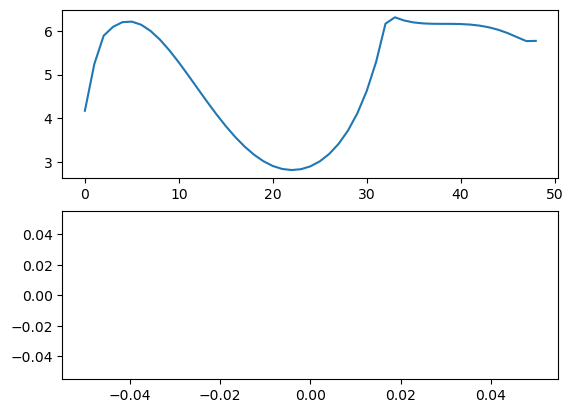

In [16]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
fig, axs, = plt.subplots(len(best_reward_decomposition),1)
for i, ax, reward_decomposition in zip(range(len(best_reward_decomposition)), axs, best_reward_decomposition):
    trajectory_id = int(reward_decomposition[0])
    trajectory = rewards_and_trajectories[i][1][trajectory_id]


    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards_and_trajectories[i][0][1][0]

    print(reward)
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    ax.plot(reward_vector)
    reward_vector
plt.show()

In [27]:
problem.mutate_JP_by_xopt(best_x)
# problem.mutate_JP_by_xopt(problem.initial_xopt)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


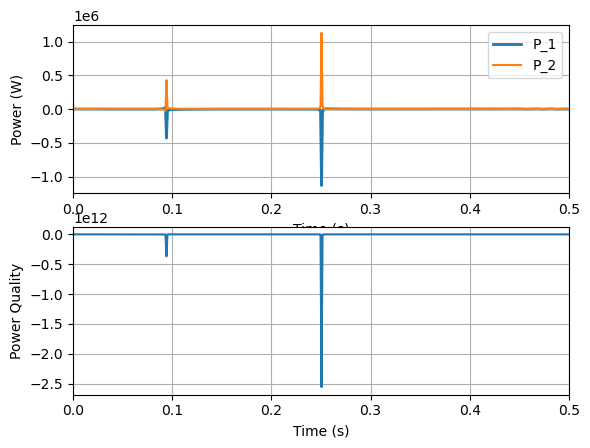

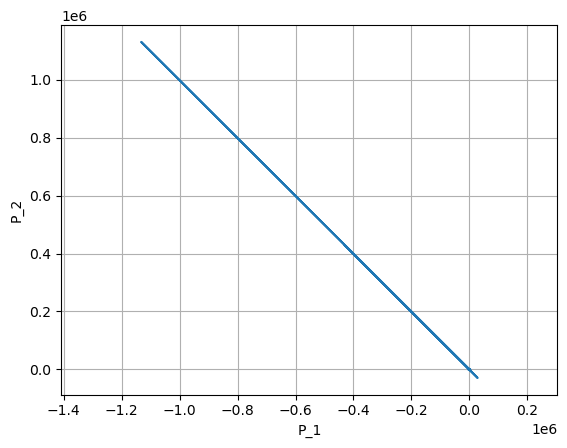

PQ: -5889105763.168767


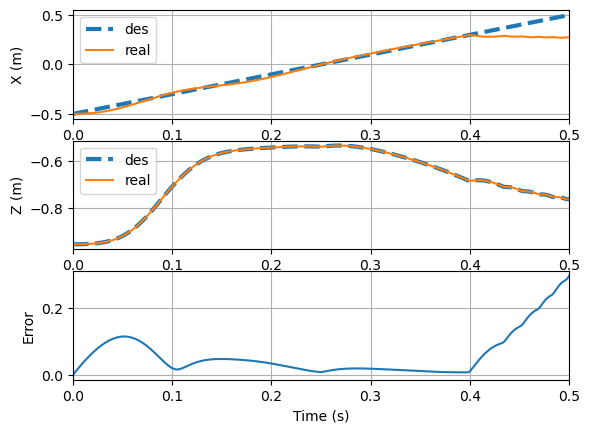

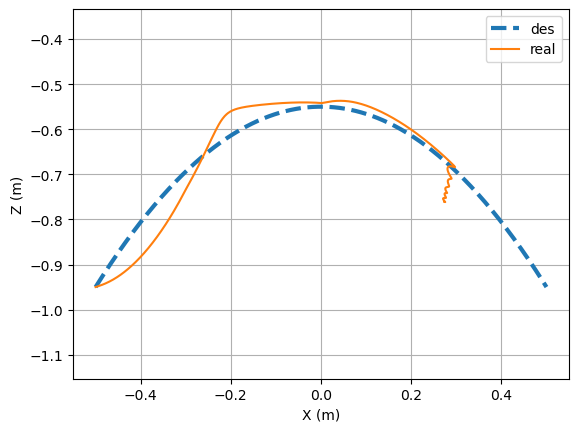

Error 0.05885196284637708


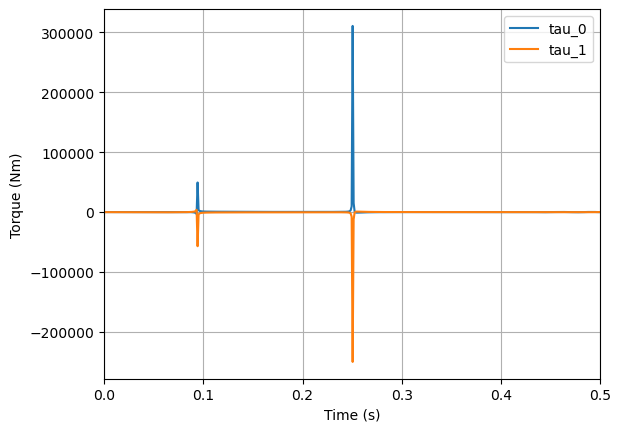

Max Torque [310903.881446   250252.39383839]


In [25]:

from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements   
import auto_robot_design.simulation.evaluation as eval

robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

name_ee = "EE"

# traj = vertical_trajectories[0][:,[0,2]]
traj =  step_trajectories[0][:,[0,2]]
test = TrajectoryMovements(traj, 0.5, 0.001, name_ee)

time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
# test.prepare_trajectory(robo)
# Kp, Kd = test.optimize_control(robo)

# test.Kp = Kp
# test.Kd = Kd

q, vq, acc, tau, pos_ee, power = test.simulate(robo, True)


print(f"PQ: {eval.power_quality(time_arr, power, True)}")
print(f"Error {eval.movments_in_xz_plane(time_arr, pos_ee, des_traj_6d[:,:3], True)}")
print(f"Max Torque {eval.torque_evaluation(time_arr, tau, True)}")

In [30]:
vertical_trajectories[0][:,2].min(), vertical_trajectories[0][:,2].max()

(-1.1, -0.6000000000000001)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


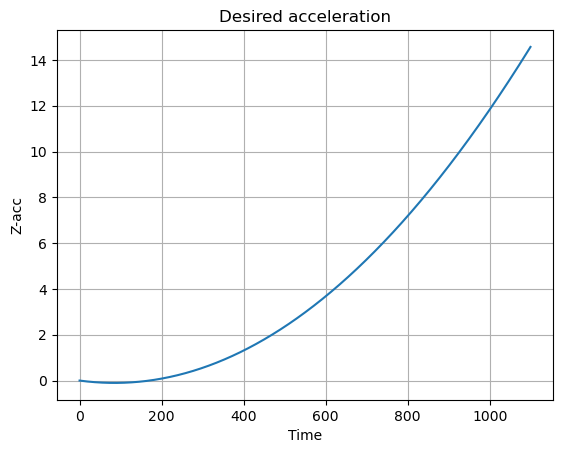

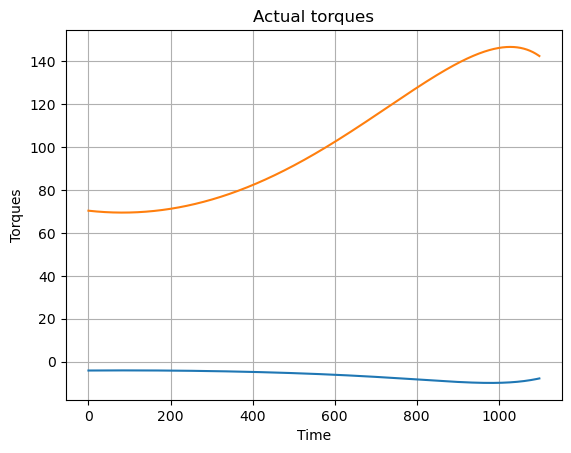

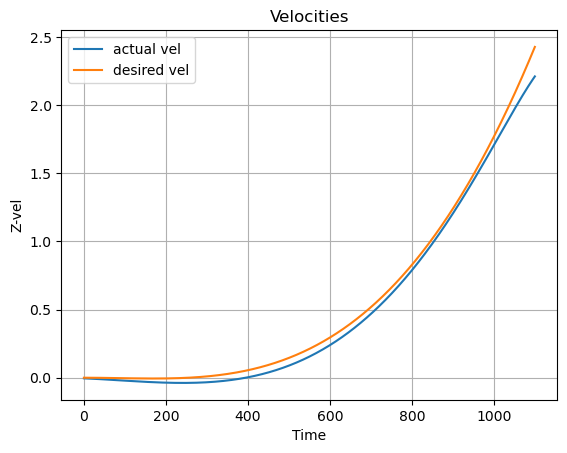

In [28]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder
from auto_robot_design.pinokla.squat import SquatHopParameters, SimulateSquatHop

robo_urdf, joint_description, loop_description = jps_graph2urdf_by_bulder(
    graph, builder)

sqh_p = SquatHopParameters(hop_flight_hight=0.3,
                           squatting_up_hight=0,
                           squatting_down_hight=-0.3,
                           total_time=0.55)
hoppa = SimulateSquatHop(sqh_p)


q_act, vq_act, acc_act, tau = hoppa.simulate(
    robo_urdf, joint_description, loop_description, is_vis=True)

trj_f = hoppa.create_traj_equation()
t = np.linspace(0, sqh_p.total_time,  len(q_act))
list__234 = np.array(list(map(trj_f, t)))


plt.figure()
plt.plot(list__234[:, 2])
plt.title("Desired acceleration")
plt.xlabel("Time")
plt.ylabel("Z-acc")
plt.grid(True)

plt.figure()
plt.plot(tau[:, 0])
plt.plot(tau[:, 1])
plt.title("Actual torques")
plt.xlabel("Time")
plt.ylabel("Torques")
plt.grid(True)


plt.figure()

plt.plot(vq_act[:, 0])
plt.plot(list__234[:, 1])
plt.title("Velocities")
plt.xlabel("Time")
plt.ylabel("Z-vel")
plt.legend(["actual vel", "desired vel"])
plt.grid(True)

plt.show()